In [1]:
from sklearn.datasets import fetch_openml

# Chapter3 MNIST

In [2]:
mnist = fetch_openml('mnist_784',version = 1);
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X,y = mnist["data"], mnist["target"];
print(X.shape);
y.shape

(70000, 784)


(70000,)

## 3.1 数据集特征
Obviously, the single data is $28\times 28$ size 
- First, show the first number
- Then, shown the 100 numbers

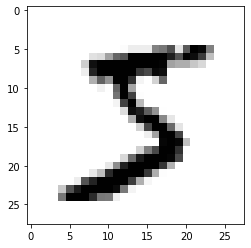

The tag is 5


In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0];
some_digit_image = some_digit.reshape(28,28);

plt.imshow(some_digit_image,cmap = 'binary');
#plt.axis("off");
plt.show();
print("The tag is "+y[0]);

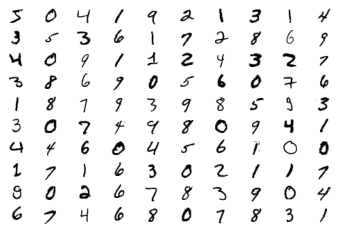

In [5]:
X_train,X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:];
digits_image = X_train.reshape(60000,28,28);
for i in range(1,101):
    plt.subplot(10,10,i);
    plt.imshow(digits_image[i-1],cmap='binary');
    plt.axis("off");
plt.show()

## 3.2 训练一个二元分类器
尝试识别一个数字，例如3，仅可以给出两个结果：3 或 非3
- *Mention: `== '3'` not `==3`*

In [6]:
y_train_3 = (y_train == '3'); #True for all 3s while False for others
y_test_3 = (y_test == '3');

from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train,y_train_3)

SGDClassifier(random_state=42)

In [7]:
sgd_clf.predict([some_digit])

array([False])

[ True]


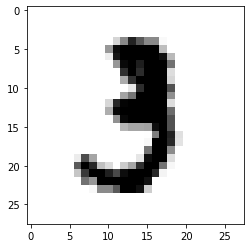

In [8]:
print(sgd_clf.predict([X_train[10]]));

plt.imshow(digits_image[10],cmap='binary');
plt.show();

## 3.3 性能测量
### 3.3.1 使用交叉验证测量准确率
- 特别是在处理偏数据集的时候，并不合适

In [9]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_3, cv=3, scoring="accuracy")

array([0.9496 , 0.9624 , 0.96275])

### 3.3.2 混淆矩阵
- 第一行表示所有“非3”的图片中：
    - 53477表示被正确分为“非3”
    - 392表示被错误分类为“3”
- 第二行表示所有“3”的图片中：
    - 2113表示被错误分类为“3”
    - 4018表示被正确的分类在了“3”

In [10]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_3,cv=3)

In [11]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_3,y_train_pred)

array([[53477,   392],
       [ 2113,  4018]])

### 3.3.3 精度和召回率
- $TP$ 是真正类，$FP$ 是假正类
$$\text{精度}=\frac{TP}{TP+FP}$$
- $TP$ 是真正类，$FN$ 是假负类
$$\text{召回率}=\frac{TP}{TP+FN}$$

**下面表示的是只有91%的概率是准确的，并且只有65.5%的数字3被检测出来。**

In [12]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_3,y_train_pred));
recall_score(y_train_3,y_train_pred)

0.9111111111111111


0.655358016636764

我们可以将召回率和精度统一成一个指标，称为 $F_1$ 分数
$$F_1=\frac{2}{\frac{1}{\text{精度}}+\frac{1}{\text{召回率}}}=\frac{TP}{TP+\frac{FN+FP}{2}}$$

In [13]:
from sklearn.metrics import f1_score
f1_score(y_train_3, y_train_pred)

0.7623565126648326

### 3.3.4 精度/召回率权衡
在权衡中，图像按照分类器评分进行排名，高于决策阈值的图像被判定为正。
**阈值越高，召回率越低，但是（通常）精度越高。**

In [14]:
y_scores = sgd_clf.decision_function([some_digit]);
y_scores

array([-3664.79262749])

In [18]:
threshold=0;
y_some_digit_pred=(y_scores>threshold)
y_some_digit_pred

array([False])

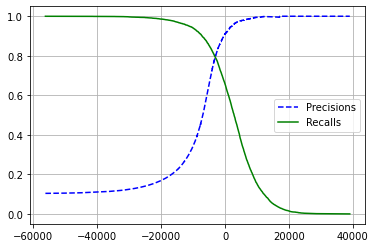

In [23]:
y_scores = cross_val_predict(sgd_clf,X_train,y_train_3,cv=3,method="decision_function");
from sklearn.metrics import precision_recall_curve
precisions,recalls,thresholds=precision_recall_curve(y_train_3,y_scores);

def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    plt.plot(thresholds,precisions[:-1],"b--",label="Precision")
    plt.plot(thresholds,recalls[:-1],"g-",label="Recall")
    plt.legend(["Precisions","Recalls"])
    plt.grid()
plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.show()

### 3.3.5 ROC Curve
- FPR：被错误分为正类的负类实例比率
- TNR：被正确分类为负类实例比率，也称为特异度
ROC：受试者工作特征曲线，其绘制的不是精度和召回率，而是真正类率（召回率）和假正类率（FPR）。**ROC曲线就是（灵敏度）和（1-特异度）的关系。**

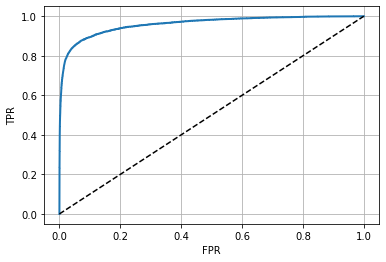

In [26]:
from sklearn.metrics import roc_curve
fpr,tpr,thresholds = roc_curve(y_train_3, y_scores);
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label);
    plt.plot([0,1],[0,1],'k--')
    plt.grid()
    plt.xlabel('FPR')
    plt.ylabel('TPR')
plot_roc_curve(fpr,tpr);
plt.show()

#### 经验法则
当正类非常少见或者更加关注假正类而不是假负类的时候，应该选择PR曲线，反之则选择ROC曲线。

## 3.4 多类分类器
- $OvR$策略：训练多个二元分类器，每个数字一个，然后在对图片进行检测分类时获得每个分类器的决策分数，比较高低。
- $OvO$策略：对于 $N$ 个类别，需要训练 $N\times (N-1)/2$ 个二元分类器（用于区别0和1，0和2，1和2……）。主要优点在于每个分类器只需要用到部分训练集对其必须区分的两个类进行训练。

In [28]:
from sklearn.svm import SVC
svm_clf = SVC();
svm_clf.fit(X_train,y_train); #y_train, not y_train_3
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [30]:
cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

我们对输入进行预处理，可以得到更好的结果。

In [31]:
from sklearn.preprocessing import StandardScaler
import numpy as np
scaler = StandardScaler();
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64));
cross_val_score(sgd_clf,X_train_scaled,y_train,cv=3,scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## 3.5 误差分析
首先，我们求出混淆矩阵，然后利用`Matplotlib`的`matshow()`函数来查看混淆矩阵的图像

In [32]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3);
conf_mx = confusion_matrix(y_train,y_train_pred);
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

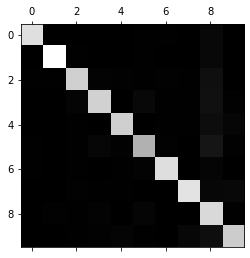

In [33]:
plt.matshow(conf_mx,cmap = plt.cm.gray);
plt.show()

由于上图显示的是错误的绝对值而不是错误率，要得到错误率我们就需要将混淆矩阵中的每个值都除以相应图片的数量。

我们用0填充对角线，只保留错误，重新绘制图像。
- 每行代表实际类，每列表示预测类。
第八列看起来很亮，说明许多图片被错误分成了数字8。但是第八列不那么差，说明数字8被正确分类为数字8.
- 错误并不是完全对称的。

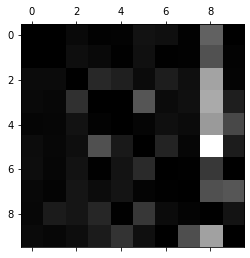

In [35]:
row_sums = conf_mx.sum(axis = 1, keepdims = True);
norm_conf_mx = conf_mx/row_sums;

np.fill_diagonal(norm_conf_mx, 0);
plt.matshow(norm_conf_mx,cmap=plt.cm.gray);
plt.show()

## 3.6 多标签类
在之前的实验中，我们仅仅将每一个实例分在了一个类中，但是在某些情况下，我们希望分类器将其分类在多个类中。比如：在一张图片中识别多个人脸。

比如，图片中有A，C，没有B。则输出应该是 $[1,0,1]$
- 下面这个例子中，创建了2个标签：是否大于等于7、是否为奇数。

In [47]:
from sklearn.neighbors import KNeighborsClassifier
y_train = y_train.astype(int);
y_train_large = (y_train >= 7);
y_train_odd = (y_train % 2 == 1);
y_multilabel = np.c_[y_train_large, y_train_odd];

knn_clf = KNeighborsClassifier();
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [49]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [50]:
y_train_knn_pred = cross_val_predict(knn_clf,X_train,y_multilabel,cv=3);
f1_score(y_multilabel,y_train_knn_pred,average="macro")

0.976410265560605

## 3.7 多输出类
简单来说，它是多标签分类的泛化，其标签也可以是多类的（比如它可以有两个以上的值）。

In [51]:
noise = np.random.randint(0,100,(len(X_train),784));
X_train_mod = X_train + noise;
noise = np.random.randint(0,100,(len(X_test),784));
X_test_mod = X_test + noise;
y_train_mod = X_train;
y_test_mod = X_test;

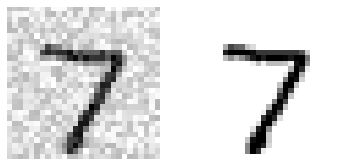

In [56]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

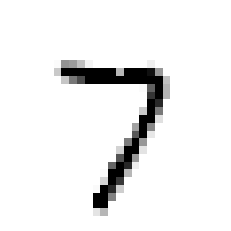

In [57]:
knn_clf.fit(X_train_mod,y_train_mod);
clean_digit = knn_clf.predict([X_test_mod[some_index]]);
plot_digit(clean_digit)